# E-06. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

##  1.모듈 및 데이터 불러오기



## Reference
- EDA : https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering
- Model : https://www.kaggle.com/tmheo74/11th-solution-public-98316-private-99336/data

In [7]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import os
from os.path import join
import pandas as pd
import numpy as np


import missingno as msno


RANDOM_SEED = 2021
np.random.seed(RANDOM_SEED)

import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
# from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer #Analysis 
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from scipy.special import boxcox1p
from sklearn.model_selection import GridSearchCV

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 1000)

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'



In [8]:
def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))
    
def load_data():
    
        train_data_path = join(data_dir, 'train.csv')
        test_data_path = join(data_dir, 'test.csv')
        train = pd.read_csv(train_data_path)
        test = pd.read_csv(test_data_path)
        
        train_copy = train.copy()
        test_copy = test.copy()
        train_copy['data'] = 'train'
        test_copy['data'] = 'test'
        test_copy['price'] = np.nan

        train_copy = train_copy[~((train_copy['sqft_living'] > 12000) & (train_copy['price']< 3000000))].reset_index(drop=True) # 이상치 제거
        # train_copy['date'] = train_copy['date'].apply(lambda i: i[:6]).astype(int) # 년,월로 전처리
          

        data = pd.concat([train_copy,test_copy], sort=False).reset_index(drop=True)  
        data = data[train_copy.columns]  
        
        data.drop('date', axis=1, inplace=True)  
        data['zipcode'] = data['zipcode'].astype(str)
        target_col = ['price']

        for i in target_col:
            data[i] = np.log1p(data[i])
        
        return data

def train_test_split(data, ideal=True):
        df = data.drop(['id','price','data'], axis=1).copy() # 데이터 값을 복사하여 저장
        cat_cols = df.select_dtypes('object').columns  # dtype이 object인 컬럼 date,zipcode 선택
        for col in cat_cols: 
            if ideal:
                ohe_df = pd.get_dummies(df[[col]], prefix='ohe_'+col) #zipcode 및 date에 가변수 만들기
                df.drop(col, axis=1, inplace=True) # 기존 컬럼이던 zipcode, date 제거
                df = pd.concat([df, ohe_df], axis=1) # 데이터와 가변수 컬럼 합치기
            else:
                le = LabelEncoder() # 문자를 수치화(숫자를 문자로 매핑)
                df[col] = le.fit_transform(df[col]) # 
                
        train_len = data[data['data'] == 'train'].shape[0]
        X_train = df.iloc[:train_len]
        X_test = df.iloc[train_len:]
        y_train = data[data['data'] == 'train']['price']

        return X_train,X_test,y_train

def get_oof_lgb(X_train, y_train, X_test, lgb_param, verbose_eval=False, return_cv_score_only=False):

    folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) # 교차검증
    oof = np.zeros(len(X_train))  
    predictions = np.zeros(len(X_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        if verbose_eval > 0: print(f'Fold : {fold_ + 1}')
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        num_round = 100000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds=200)
        oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
        predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
        
        cv_fold_score = rmse_exp(y_train.iloc[val_idx], oof[val_idx])
        
        if verbose_eval > 0: print(f'Fold {fold_ + 1} / CV-Score: {cv_fold_score:.6f}')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns.tolist()
        fold_importance_df['importance'] = clf.feature_importance('gain')
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cv_score = rmse_exp(y_train, oof)
    print(f'CV-Score: {cv_score:.6f}')
    if return_cv_score_only: return cv_score
    else: return oof, predictions, cv_score, feature_importance_df

def plot_categorical_for_regression(df, field, target_field='price', show_missing=True, missing_value='NA'):
    df_copy = df.copy()
    if show_missing: df_copy[field] = df_copy[field].fillna(missing_value)
    df_copy = df_copy[df_copy[field].notnull()]

    ax1_param = 121
    ax2_param = 122
    fig_size = (16, 7)
    if df_copy[field].nunique() > 30:
        ax1_param = 211
        ax2_param = 212
        fig_size = (16, 10)
    
    fig = plt.figure(figsize = fig_size)
    ax1 = plt.subplot(ax1_param)
    
    sns.countplot(x=field, hue='data', order=np.sort(df_copy[field].unique()), data=df_copy)
    plt.xticks(rotation=90, fontsize=11)
    
    ax2 = plt.subplot(ax2_param)
    
    df_copy = df_copy[df_copy['data'] == 'train']

    sns.boxplot(x=field, y=target_field, data=df_copy, order=np.sort(df_copy[field].unique()), ax=ax2)
    plt.xticks(rotation=90, fontsize=11)
    
    plt.show()

def plot_numeric_for_regression(df, field, target_field='price'):
    df = df[df[field].notnull()]

    fig = plt.figure(figsize = (16, 7))
    ax1 = plt.subplot(121)
    
    sns.distplot(df[df['data'] == 'train'][field], label='Train', hist_kws={'alpha': 0.5}, ax=ax1)
    sns.distplot(df[df['data'] == 'test'][field], label='Test', hist_kws={'alpha': 0.5}, ax=ax1)

    plt.xlabel(field)
    plt.ylabel('Density')
    plt.legend()
    
    ax2 = plt.subplot(122)
    
    df_copy = df[df['data'] == 'train'].copy()

    sns.scatterplot(x=field, y=target_field, data=df_copy, ax=ax2)
    
    plt.show()

def plot_feature_importance(fi_df, num_feature=20):
    cols = (fi_df[['feature', 'importance']]
            .groupby('feature')
            .mean()
            .sort_values(by='importance', ascending=False)[:num_feature].index)
    best_features = fi_df.loc[fi_df.feature.isin(cols)]

    sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
    plt.title('Feature Importances (averaged over folds)')
    plt.tight_layout()
    plt.show()




## 2. 데이터 전처리(EDA)

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [9]:
data = load_data()
print(data.shape)
data.head(5)

(21502, 21)


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,data
0,0,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,train
1,1,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,train
2,2,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,train
3,3,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,train
4,4,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,train


In [10]:
X_train, X_test, y_train = train_test_split(data)

print(X_train.shape, X_test.shape)
lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}
oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 87) (6468, 87)
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2358
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 87
[LightGBM] [Info] Start training from score 13.051256
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 87
[LightGBM] [Info] Start training from score 13.049287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the ov

- lms : 114861.038272
- original: 115752.026477

In [11]:
fi_df[fi_df['fold']==1].sort_values('importance', ascending=False).head(20) # 특성의 중요도 별 정렬

,feature,importance,fold
13,lat,6945.769556,1
8,grade,5731.947239,1
2,sqft_living,5580.597705,1
15,sqft_living15,841.789925,1
14,long,783.480278,1
11,yr_built,635.228277,1
6,view,397.510272,1
9,sqft_above,389.911743,1
3,sqft_lot,371.372458,1
16,sqft_lot15,283.952652,1


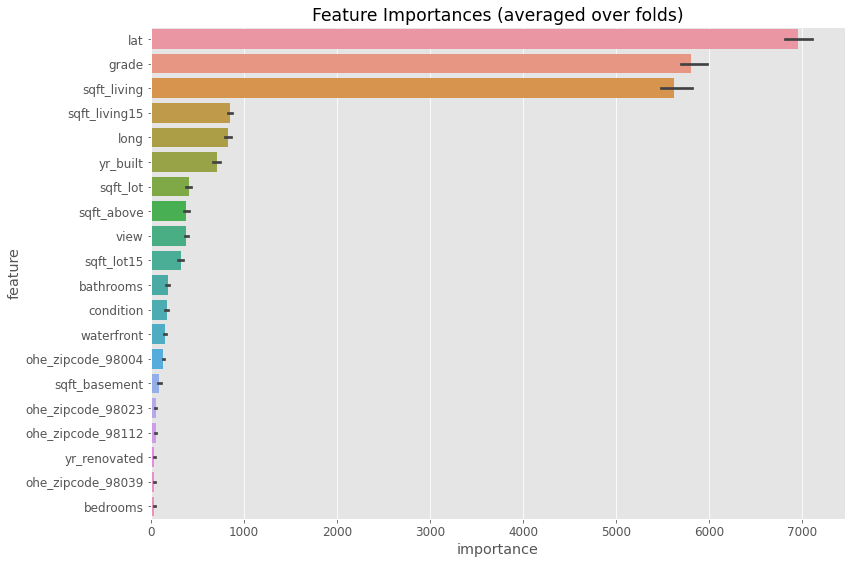

In [12]:
plot_feature_importance(fi_df)

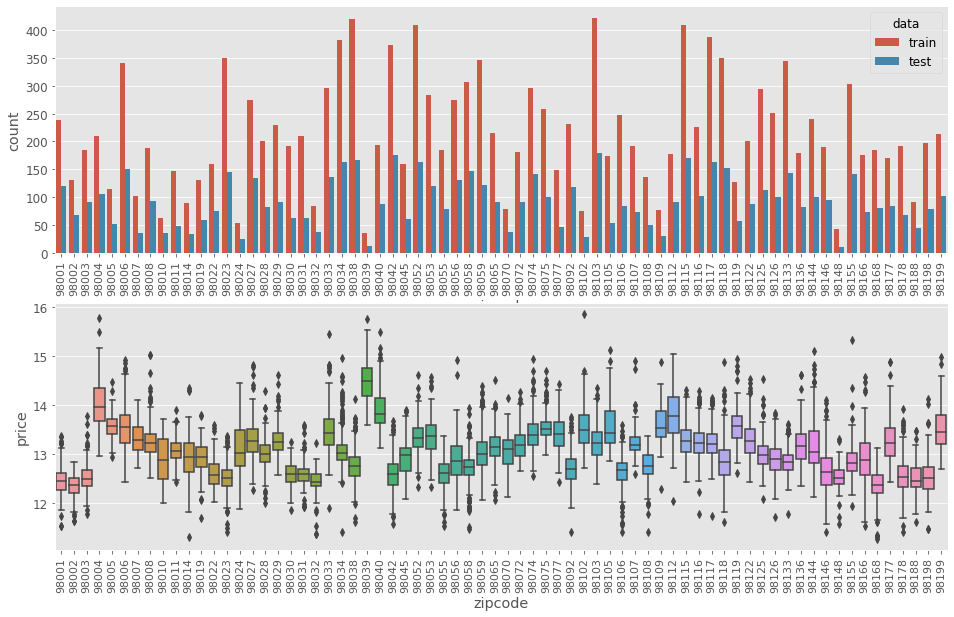

In [13]:
plot_categorical_for_regression(data, 'zipcode')

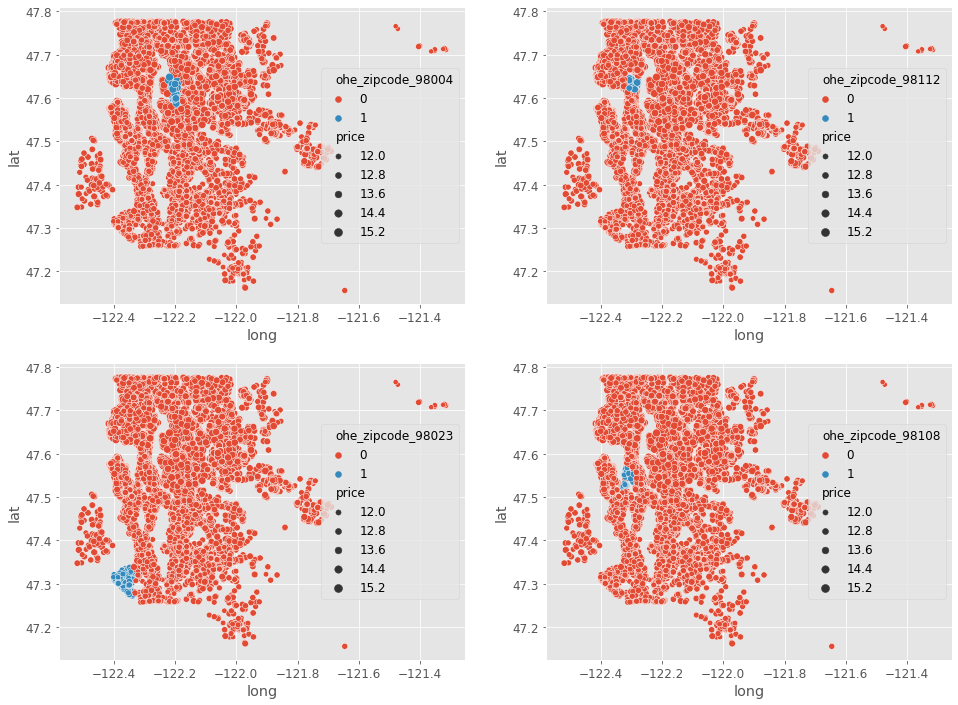

In [14]:
df = X_train
df['price'] = y_train

fig = plt.figure(figsize = (16, 12))

ax1 = plt.subplot(221)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98004', size='price', data=df, ax=ax1)

ax2 = plt.subplot(222)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98112', size='price', data=df, ax=ax2)

ax3 = plt.subplot(223)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98023', size='price', data=df, ax=ax3)

ax4 = plt.subplot(224)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98108', size='price', data=df, ax=ax4)

plt.show()

In [15]:
data = load_data()
data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

print(data.shape)
data.head()

(21502, 27)


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,data,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,0,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,train,z_1,z_7,z_8,z_17,z_78,z_18
1,1,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,train,z_0,z_2,z_8,z_02,z_28,z_08
2,2,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,train,z_0,z_7,z_4,z_07,z_74,z_04
3,3,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,train,z_0,z_0,z_3,z_00,z_03,z_03
4,4,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,train,z_1,z_9,z_8,z_19,z_98,z_18


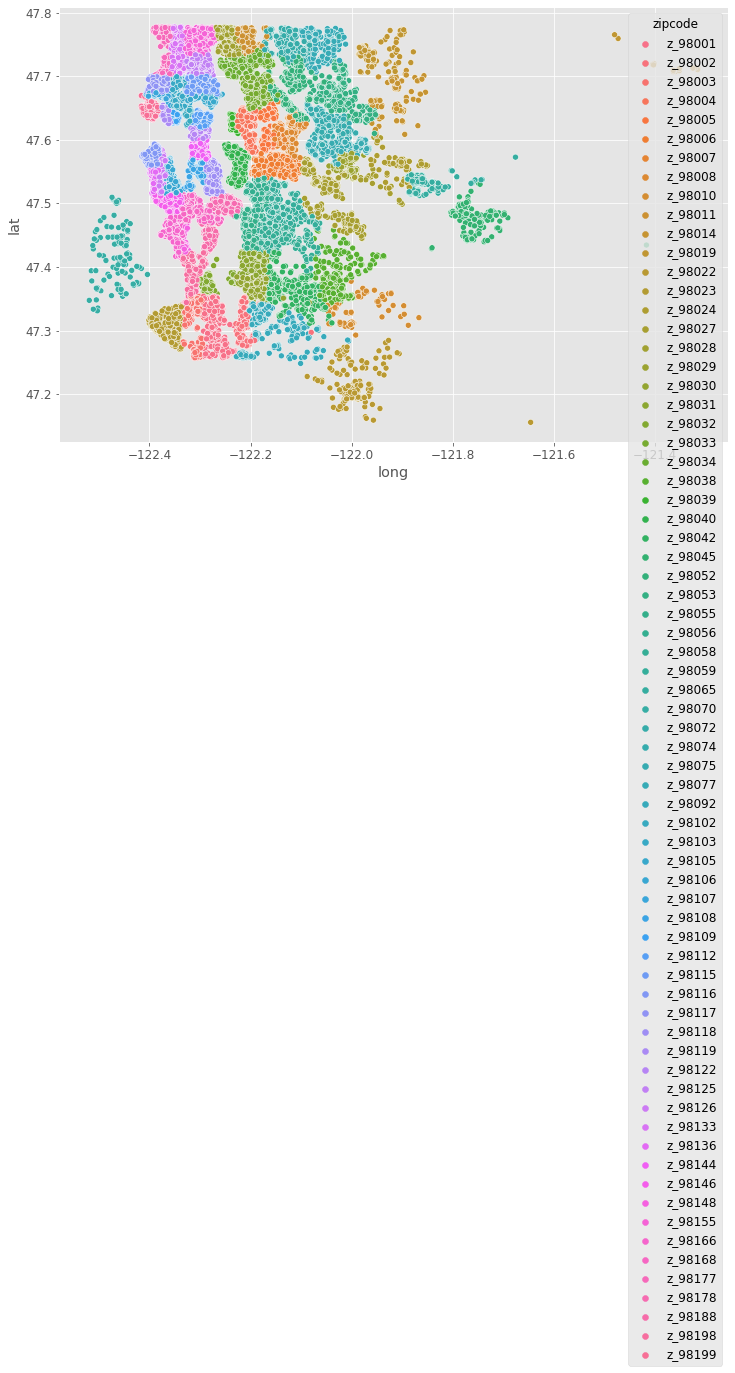

In [16]:
data['zipcode'] = 'z_' + data['zipcode']
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(data['zipcode'].unique()), data=data);

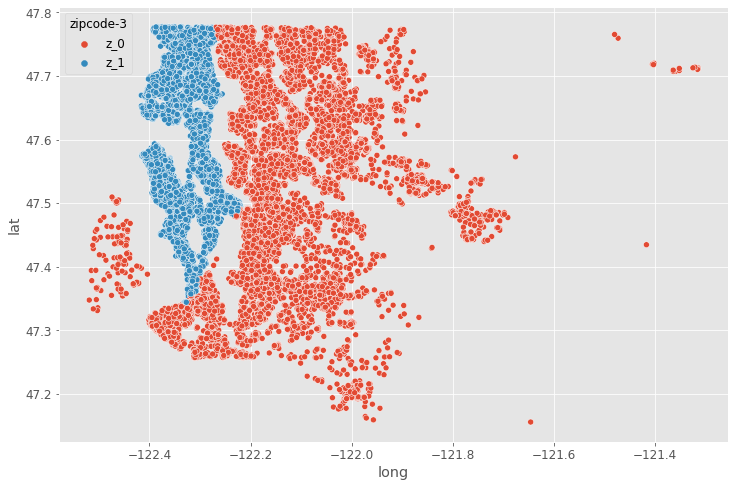

In [17]:
sns.scatterplot(x='long', y='lat', hue='zipcode-3', hue_order=np.sort(data['zipcode-3'].unique()), data=data);

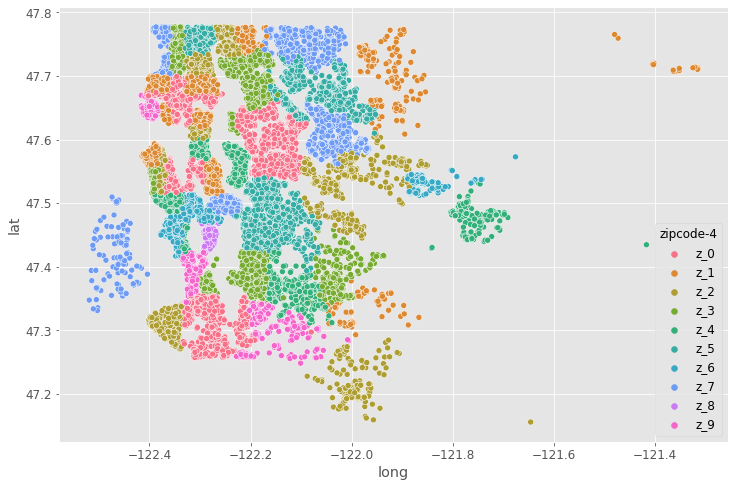

In [18]:
sns.scatterplot(x='long', y='lat', hue='zipcode-4', hue_order=np.sort(data['zipcode-4'].unique()), data=data);

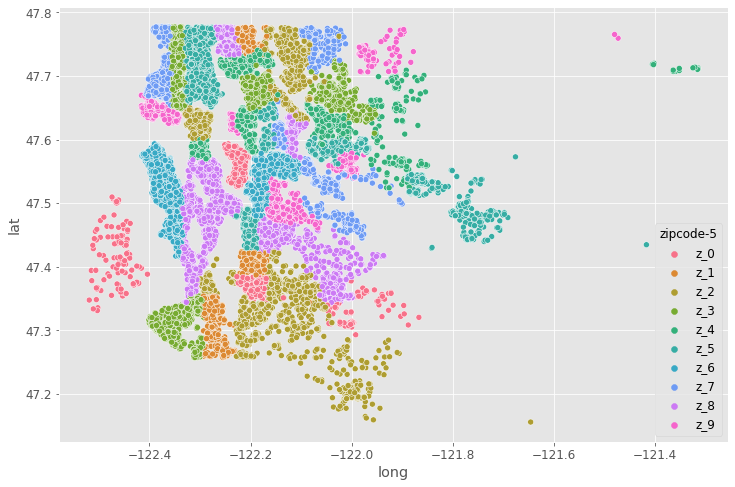

In [19]:
sns.scatterplot(x='long', y='lat', hue='zipcode-5', hue_order=np.sort(data['zipcode-5'].unique()), data=data);

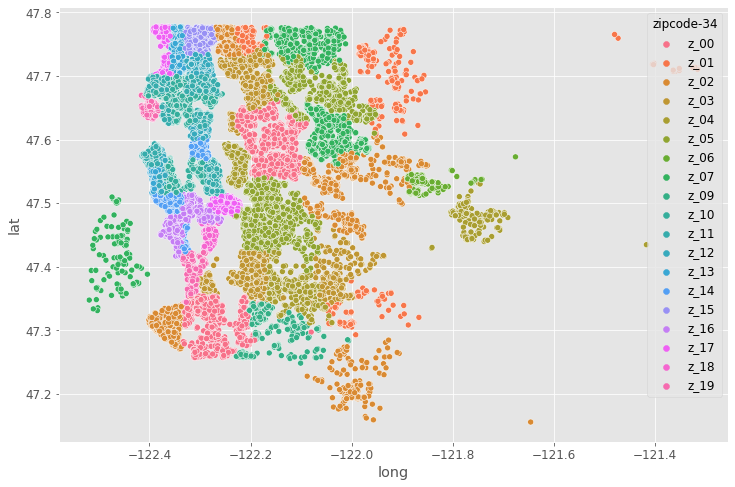

In [20]:
sns.scatterplot(x='long', y='lat', hue='zipcode-34', hue_order=np.sort(data['zipcode-34'].unique()), data=data);

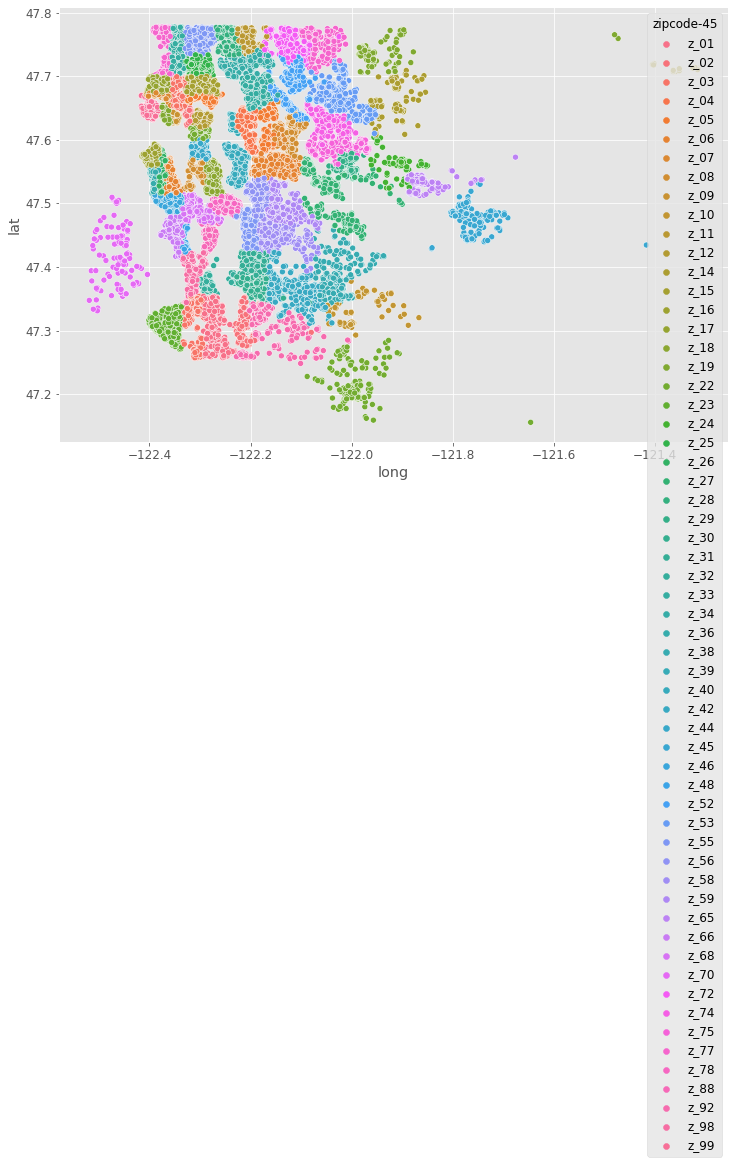

In [21]:
sns.scatterplot(x='long', y='lat', hue='zipcode-45', hue_order=np.sort(data['zipcode-45'].unique()), data=data);

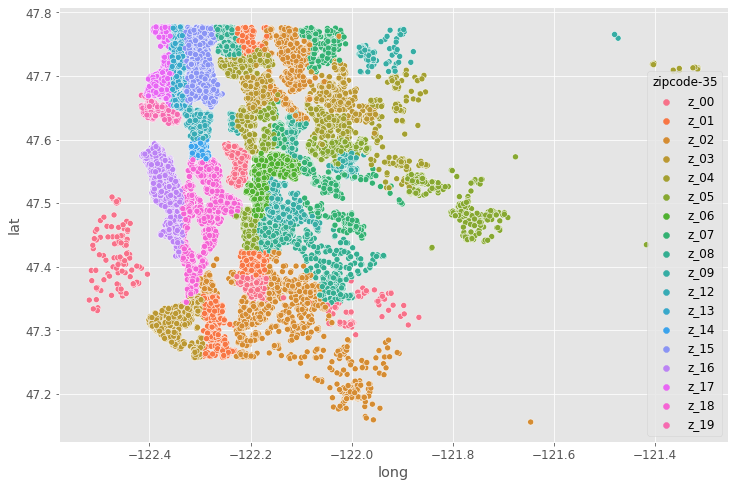

In [22]:
sns.scatterplot(x='long', y='lat', hue='zipcode-35', hue_order=np.sort(data['zipcode-35'].unique()), data=data);

In [23]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 205) (6468, 205)
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2594
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 205
[LightGBM] [Info] Start training from score 13.051256
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2614
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 205
[LightGBM] [Info] Start training from score 13.049287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove th

- zipcode 추가후 score : 116841.454703

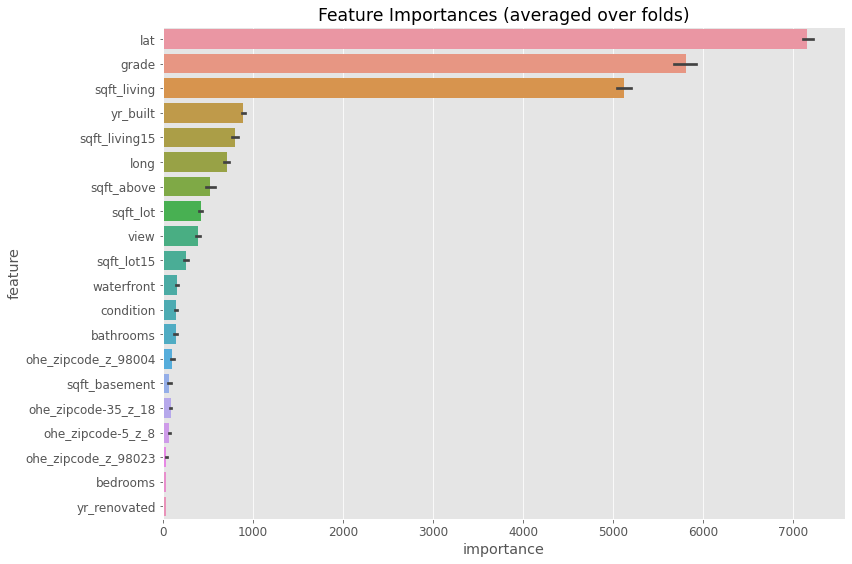

In [24]:
plot_feature_importance(fi_df)

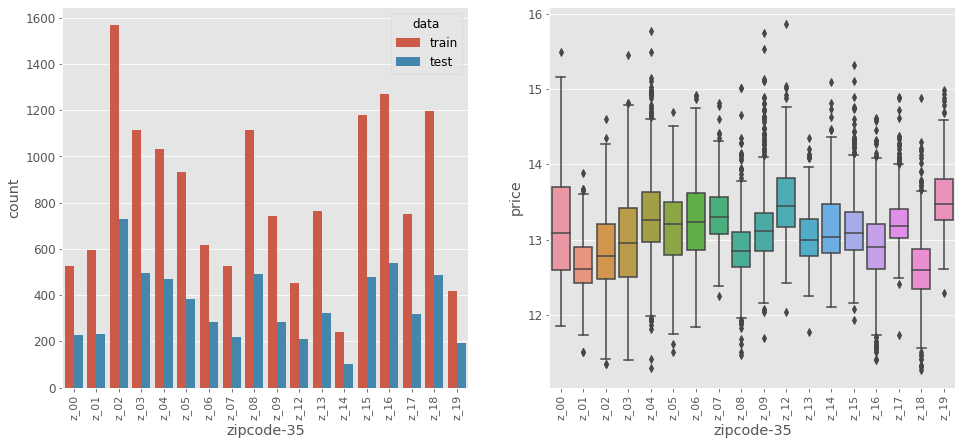

In [25]:
plot_categorical_for_regression(data, 'zipcode-35')

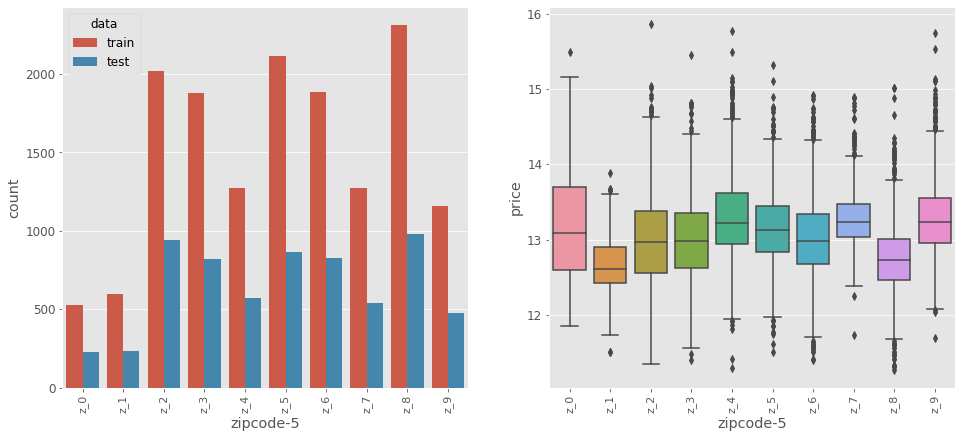

In [26]:
plot_categorical_for_regression(data, 'zipcode-5')

# kmeans - Lat, Long

In [ ]:
k_range = range(2, 80, 5)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
    coord_cluster = kmeans.predict(coord)
    data['coord_cluster'] = coord_cluster
    data['coord_cluster'] = data['coord_cluster'].map(lambda x: str(x).rjust(2, '0'))
    
    X_train, X_test, y_train = train_test_split(data)

    lgb_param = {
        'objective': 'regression',
        'learning_rate': 0.05,
        'num_leaves': 15,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'feature_fraction': 0.7,
        'seed': RANDOM_SEED,
        'metric': ['rmse'],
    }

    print('K :', k)
    get_oof_lgb(X_train, y_train, X_test, lgb_param)
    print()

K : 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 89
[LightGBM] [Info] Start training from score 13.051256
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2382
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 89
[LightGBM] [Info] Start training from score 13.049287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

In [ ]:
k_range = range(28, 37)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
    coord_cluster = kmeans.predict(coord)
    data['coord_cluster'] = coord_cluster
    data['coord_cluster'] = data['coord_cluster'].map(lambda x: str(x).rjust(2, '0'))
    
    X_train, X_test, y_train = train_test_split(data)

    lgb_param = {
        'objective': 'regression',
        'learning_rate': 0.05,
        'num_leaves': 15,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'feature_fraction': 0.7,
        'seed': RANDOM_SEED,
        'metric': ['rmse'],
    }

    print('K :', k)
    get_oof_lgb(X_train, y_train, X_test, lgb_param)
    print()

K : 28
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2412
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 114
[LightGBM] [Info] Start training from score 13.051256
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 114
[LightGBM] [Info] Start training from score 13.049287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

In [ ]:
# kmeans for lat, long
kmeans = KMeans(n_clusters=32, random_state=RANDOM_SEED).fit(coord)
coord_cluster = kmeans.predict(coord)
data['coord_cluster'] = coord_cluster
data['coord_cluster'] = data['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

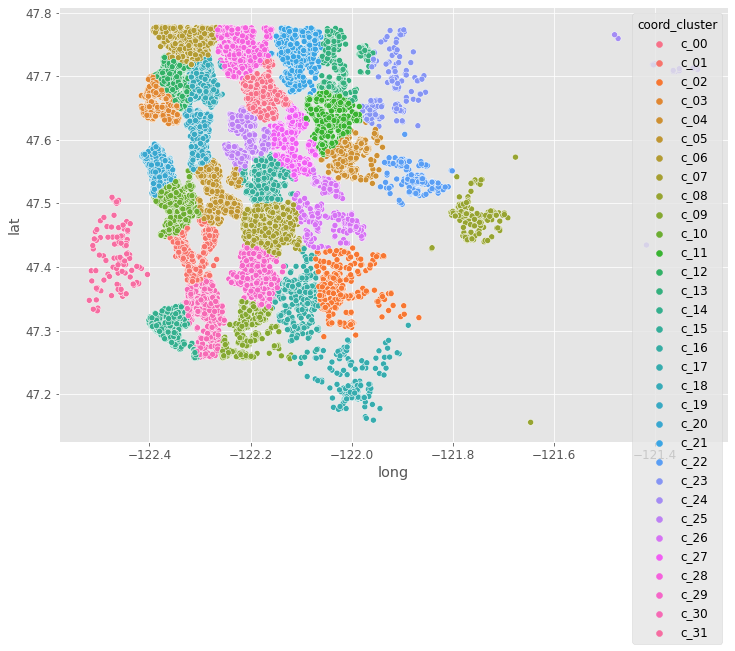

In [ ]:
sns.scatterplot(x='long', y='lat', hue='coord_cluster', hue_order=np.sort(data['coord_cluster'].unique()), data=data);

In [ ]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 119) (6468, 119)
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2420
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 118
[LightGBM] [Info] Start training from score 13.051256
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2440
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 118
[LightGBM] [Info] Start training from score 13.049287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove th

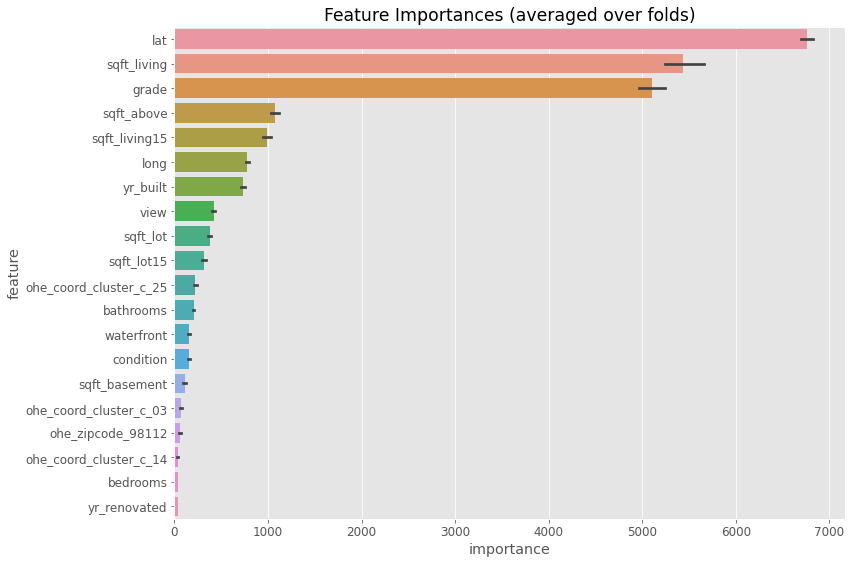

In [ ]:
plot_feature_importance(fi_df)

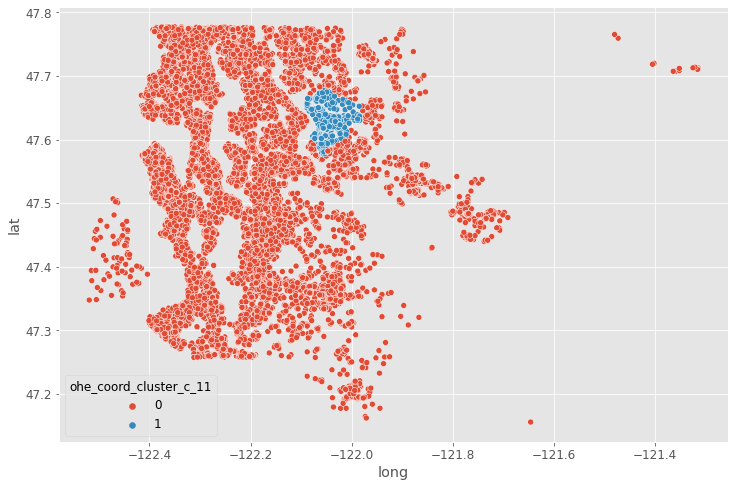

In [ ]:
df = X_train
df['price'] = y_train
sns.scatterplot(x='long', y='lat', hue='ohe_coord_cluster_c_11', data=df);

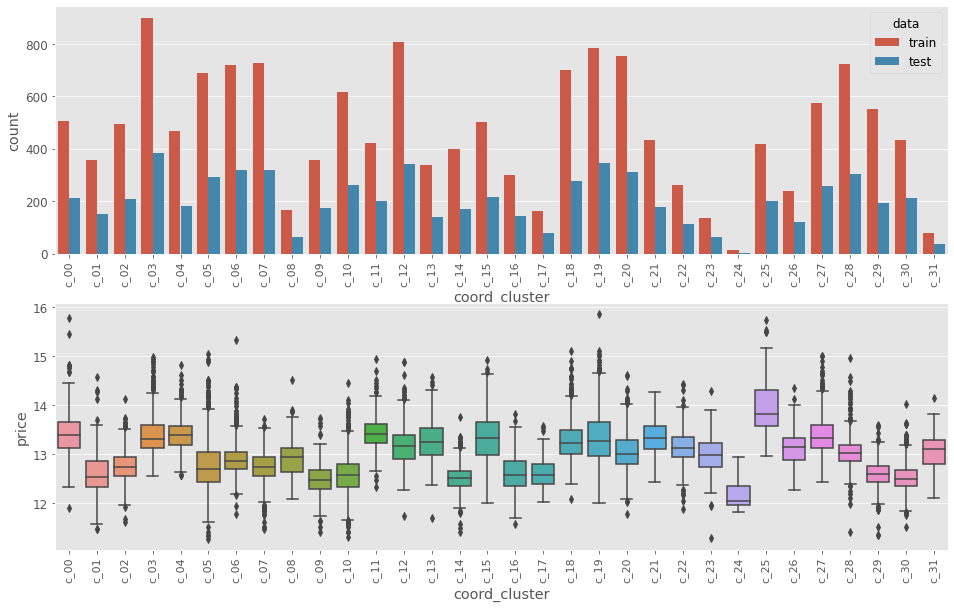

In [ ]:
plot_categorical_for_regression(data, 'coord_cluster')

# Haversine Distance

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2): 
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) 
    AVG_EARTH_RADIUS = 6371 # in km 
    lat = lat2 - lat1 
    lng = lng2 - lng1 
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2 
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)) 
    return h

In [ ]:
print(data['lat'].min(), data['lat'].max(), data['long'].min(), data['long'].max())

haversine_dist = haversine_array(data['lat'].min(), data['long'].min(), data['lat'].max(), data['long'].max())
print(f'max distance: {haversine_dist:.2f}km')

47.1559 47.7776 -122.519 -121.315
max distance: 113.88km


In [ ]:
neighbor_df = pd.DataFrame()
lat2 = data['lat'].values
long2 = data['long'].values

lat1 = data.loc[0, 'lat'] # id = 0 house lat
long1 = data.loc[0, 'long'] # id = 0 house long
dist_arr = haversine_array(lat1, long1, lat2, long2)
neighbor_df = pd.DataFrame({
    'id': np.tile(np.array([data.loc[0, 'id']]), data.shape[0]),
    'neighbor_id': data['id'],
    'neighbor_lat': lat2,
    'neighbor_long': long2,
    'distance': dist_arr,
})
    
print(neighbor_df.shape)
neighbor_df.head()

(21502, 5)


,id,neighbor_id,neighbor_lat,neighbor_long,distance
0,0,0,47.5112,-122.257,0.000000
1,0,1,47.7379,-122.233,25.271977
2,0,2,47.6168,-122.045,19.771055
3,0,3,47.3097,-122.327,23.016635
4,0,4,47.4095,-122.315,12.120049


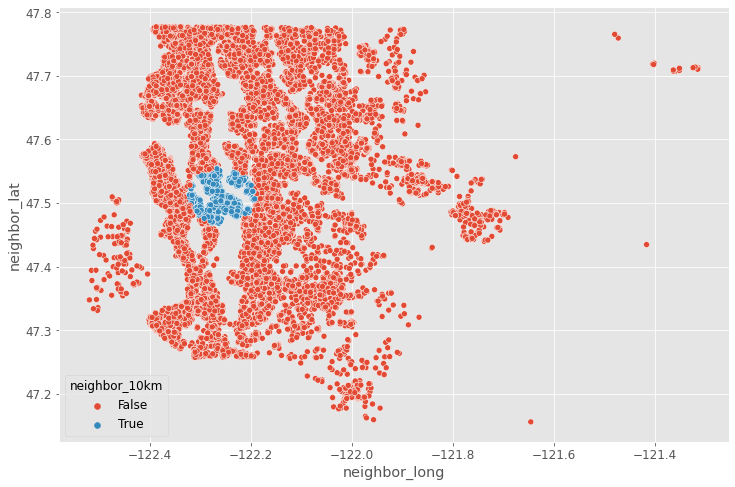

In [ ]:
neighbor_df['neighbor_10km'] = neighbor_df['distance'] <= 5
sns.scatterplot(x='neighbor_long', y='neighbor_lat', hue='neighbor_10km', data=neighbor_df);

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [37]:
gboost = GradientBoostingRegressor(random_state=RANDOM_SEED)
xgboost = XGBRegressor(random_state=RANDOM_SEED)
lightgbm = LGBMRegressor(random_state=RANDOM_SEED)
rdforest = RandomForestRegressor(random_state=RANDOM_SEED)

models = [gboost, xgboost, lightgbm, rdforest]

In [50]:
def get_scores(models, x, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=RANDOM_SEED, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse_exp(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE')
            
    return score_df

get_scores(models, X_train, y_train)

,RMSE
LGBMRegressor,124953.069279
XGBRegressor,127126.932461
GradientBoostingRegressor,134077.277505
RandomForestRegressor,135424.113326


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(x, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

print('done')

done


In [42]:
param_grid = {
    'learning_rate' : [0.034, 0.035, 0.036],
    'n_estimators': [930, 940, 950],
    'max_depth': [15, 16,17],
}
model = LGBMRegressor(random_state=RANDOM_SEED)
my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   55.0s
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed:  3.7min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
8,0.034,17,950,-0.026337,0.162288
6,0.034,17,930,-0.026344,0.162307
7,0.034,17,940,-0.026348,0.162319
1,0.034,15,940,-0.026364,0.162371
2,0.034,15,950,-0.026365,0.162372
0,0.034,15,930,-0.026365,0.162373
5,0.034,16,950,-0.026369,0.162386
3,0.034,16,930,-0.026371,0.162390
4,0.034,16,940,-0.026371,0.162391
24,0.036,17,930,-0.026430,0.162574


In [46]:
def save_submission(model, x, y, test, model_name, rmsle=None):
    model.fit(x, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = 'aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))



In [47]:
model = LGBMRegressor(learning_rate = 0.035, max_depth=16, n_estimators=940, random_state=RANDOM_SEED)
save_submission(model,X_train, y_train, X_test, 'lgbm', rmsle='0.159795')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.159795.csv saved!


In [55]:
!pip install IPython 

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


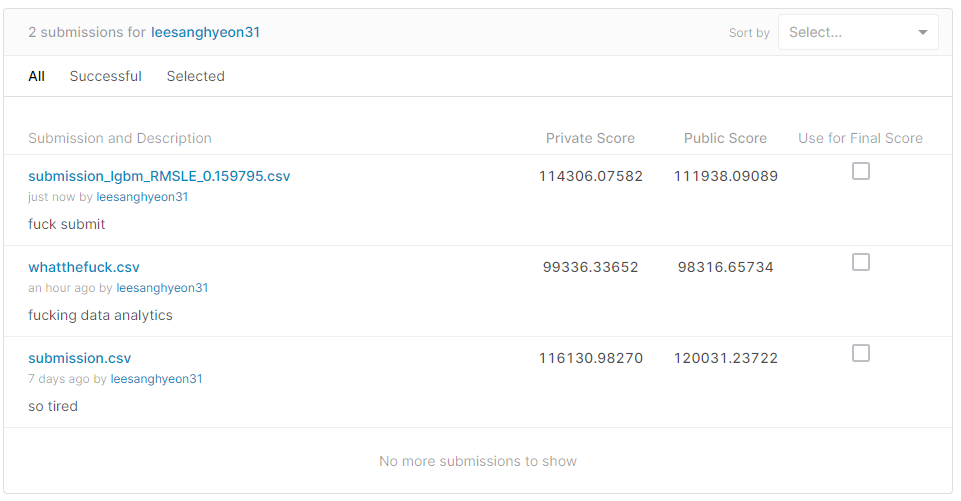

In [57]:
from IPython.display import Image
Image("aiffel/kaggle_kakr_housing/data/1.png")

## 회고
- 진짜 평가좋은 코드들을 분석해서 EDA 하고 이것저것 실험해봤으나 나중 되니 시간만 부족하고 너무 EDA랑 데이터 전처리에 대해 많은 공부를 한 것이 아닌가 싶다. 모델도 여러모델에 대해서 그리고 18번 노드에 대한게 여러 케글 코드를 통해서 보게 되면서 좋은 공부가 되었던 것 같다 물론 결과는 시간이 촉박해서 대충한지라 좋게는 못 나왔지만 나름에 성장이 되었다고 생각한다. 원래 같으면 이것저것 분석하고 구체적으로 정리를 할려고 했으나 너무 시간과 체력이 없어서 운동에 중요성을 다시금 깨닫게 되는 일주일이였다..